In [1]:
# File utils
import json
import pickle
import glob

# Preprocessing utils
import unidecode
import re
from collections import defaultdict
import editdistance

# Debugging
from IPython.core.debugger import Tracer

In [2]:
with open("IMP_paper_global_id_dict.pkl", "rb") as f:
    paper_global_id_dict = pickle.load(f)

with open("IMP_paper_id_titles.pkl", "rb") as f:
    paper_id_titles = pickle.load(f)

In [4]:
with open('iclr_ref_arxiv_map.pkl', "rb") as f:
    iclr_ref_arxiv_map = pickle.load(f)

In [ ]:
iclr_ref_arxiv_map

In [50]:
bbl_absent = []
bbl_multiple = []
bbl_unique = []
not_bib = []

exceptions_ids = []

paper_bbl_dict = {}

In [36]:
k = 598027
arxivid = iclr_ref_arxiv_map[k]
dir_name = arxivid.split(".")[0]
k, arxivid

(598027, '0712.4402')

In [37]:
glob.glob("./data/unpacked_sources/{}/{}/*.bbl".format(dir_name, arxivid))

['./data/unpacked_sources/0712/0712.4402/judgment5.bbl']

In [51]:
# DO THIS WITH CAUTION: THIS WILL REQUIRE THE TITLS TO BE DISAMBIGUATED AGAIN WHICH TAKES AROUND 4-5 HOURS
# Basically the portion where each of the reference is compared against all titles in the arxiv dump to map it back to an arxiv id.

for k in iclr_ref_arxiv_map:
    arxivid = iclr_ref_arxiv_map[k]
    
    dir_name = arxivid.split(".")[0]
    
    # Read the bbl file to extract references
    potential_bbl_files = glob.glob("./data/unpacked_sources/{}/{}/*.bbl".format(dir_name, arxivid))
    all_tex_in_dir_for_multiple_bbl = glob.glob("./data/unpacked_sources/{}/{}/*.tex".format(dir_name, arxivid))

    if len(potential_bbl_files) >= 1:
        
        annotate_seq = False
        bib_item_seq_number = None
        
        if len(potential_bbl_files) > 1:
            read_texts_bib_all = []
            
            NEW_potential_bbl_files = []
            for bbbbbb in potential_bbl_files:
                only_first_name = bbbbbb.replace(".bbl", ".tex")
                if only_first_name in all_tex_in_dir_for_multiple_bbl:
                    NEW_potential_bbl_files.append(bbbbbb)
            potential_bbl_files = NEW_potential_bbl_files
            
            for bbbbbb in potential_bbl_files:
                with open(bibfileiter, "r", errors="ignore") as f:
                    read_texts_bib_all.append(f.read())
            same_text = False
            for iter_, text_iter in enumerate(read_texts_bib_all):
                if iter_ < len(read_texts_bib_all)-1:
                    if text_iter.lower() == read_texts_bib_all[iter_+1].lower():
                        same_text = True
                    else:
                        same_text = False
                        break
                else:
                    break
            if same_text:
                potential_bbl_files = [potential_bbl_files[0]]
        
        
        if len(potential_bbl_files) == 1:
            annotate_seq = True
            bib_item_seq_number = 1
            bbl_unique.append(k)
        else:
            bbl_multiple.append(k)
        
        try:
            paper_bibitems = {}
            
            for bibfileiter in potential_bbl_files:
                with open(bibfileiter, "r", errors="ignore") as f:
                    lines = f.readlines()
                
                bibitem = []
                start_looking = True
                start_appending = False
                
                for l in lines:
                    if start_looking and (l.startswith("\\bibitem[") or l.startswith("\\bibitem{")):
                        start_looking = False
                        start_appending = True
                        bibitem = [l.strip().replace("\n", " ")]
                        continue
                    if start_appending:
                        if l == "\n":
                            bib_text = " ".join(bibitem)
                            cit_key = None
                            
                            if bib_text.startswith("\\bibitem["):
                                if bib_text.startswith("\\bibitem[\\protect\\citeauthoryear"):
                                    cit_key = None
                                    m = re.search('\\\\bibitem\[.*?\]%? ?({.*?})', bib_text)
                                    if m:
                                        cit_key = m.group(1)[1:-1]
                                    else:
                                        print("NOT FOUND CIT KEY[citauthor]: ", bibfileiter, bib_text)
                                else:
                                    m = re.search('\\\\bibitem\[.*?\]({.*?})', bib_text)
                                    if m:
                                        cit_key = m.group(1)[1:-1]
                                    else:
                                        print("NOT FOUND CIT KEY[]: ", bibfileiter, bib_text)
                                    
                            if bib_text.startswith("\\bibitem{"):
                                m = re.search('\\\\bibitem({.*?})', bib_text)
                                if m:
                                    cit_key = m.group(1)[1:-1]
                                else:
                                    print("NOT FOUND CIT KEY{}: ", bibfileiter, bib_text)
                            
                            if not cit_key is None:
                                if bib_item_seq_number:
                                    paper_bibitems[cit_key] = {"text": bib_text, "arxivids": [], "bib-seq": bib_item_seq_number}
                                else:
                                    paper_bibitems[cit_key] = {"text": bib_text, "arxivids": []}

                            bibitem = []
                            start_looking = True
                            start_appending = False
                            if bib_item_seq_number:
                                bib_item_seq_number += 1
                        else:
                            bibitem.append(l.strip().replace("\n", " "))
            
            if paper_bibitems:
                paper_bbl_dict[k] = paper_bibitems
            else:
                print(k, potential_bbl_files, paper_bibitems)
                
        except Exception as ex:
            print(k, ex)
            exceptions_ids.append(k)
        
    elif len(potential_bbl_files) == 0:
        bbl_absent.append(k)

868481 ['./data/unpacked_sources/1705/1705.07874/main.bbl'] {}
640065 ['./data/unpacked_sources/1510/1510.05067/liao-leibo-poggio.bbl'] {}
1000730 ['./data/unpacked_sources/1802/1802.05300/main.bbl'] {}
1156522 ['./data/unpacked_sources/1807/1807.01697/main.bbl'] {}
550361 ['./data/unpacked_sources/1610/1610.03022/paper.bbl'] {}
894715 ['./data/unpacked_sources/1803/1803.08456/rldm.bbl'] {}
1165190 ['./data/unpacked_sources/1811/1811.02633/molecular_transformer_rxiv.bbl'] {}
723260 ['./data/unpacked_sources/1604/1604.08642/IJCAI_2016.bbl'] {}
363067 ['./data/unpacked_sources/1605/1605.02688/theano2016.bbl'] {}
1002672 ['./data/unpacked_sources/1710/1710.07462/arxiv_09_2018.bbl'] {}
781750 ['./data/unpacked_sources/1709/1709.05448/main.bbl'] {}
1019975 ['./data/unpacked_sources/1708/1708.07164/nonconvex_theory.bbl'] {}
201329 ['./data/unpacked_sources/1503/1503.03578/frp0228-Tang.bbl'] {}
1151669 ['./data/unpacked_sources/1804/1804.11285/main.bbl'] {}
767816 ['./data/unpacked_sources/16

In [44]:
cat ./data/unpacked_sources/1503/1503.03578/frp0228-Tang.bbl

\begin{thebibliography}{}

\end{thebibliography}


In [48]:
# ls ./data/unpacked_sources/1503/1503.03578/frp0228-Tang.tex
!cat ./data/unpacked_sources/1503/1503.03578/frp0228-Tang.tex

% !TeX document-id = {43fe7831-d153-41f5-bffb-5a6b12ad8c33}
% !TEX TS-program = pdftex
% This is "sig-alternate.tex" V1.9 April 2009
% This file should be compiled with V2.4 of "sig-alternate.cls" April 2009
%
% This example file demonstrates the use of the 'sig-alternate.cls'
% V2.4 LaTeX2e document class file. It is for those submitting
% articles to ACM Conference Proceedings WHO DO NOT WISH TO
% STRICTLY ADHERE TO THE SIGS (PUBS-BOARD-ENDORSED) STYLE.
% The 'sig-alternate.cls' file will produce a similar-looking,
% albeit, 'tighter' paper resulting in, invariably, fewer pages.
%
% ----------------------------------------------------------------------------------------------------------------
% This .tex file (and associated .cls V2.4) produces:
%       1) The Permission Statement
%       2) The Conference (location) Info information
%       3) The Copyright Line with ACM data
%       4) NO page numbers
%
% as against the acm_proc_article-sp.cls file which
% DOES NOT produce 1) thru

In [52]:
len(bbl_absent), len(bbl_multiple), len(bbl_unique)

(261, 2, 2065)

In [53]:
len(paper_bbl_dict), list(paper_bbl_dict.items())[0]

(2043,
 (1179651,
  {'tensorflow2015-whitepaper': {'text': "\\bibitem{tensorflow2015-whitepaper} Mart\\'{\\i}n Abadi, Ashish Agarwal, Paul Barham, Eugene Brevdo, Zhifeng Chen, Craig Citro, Greg~S. Corrado, Andy Davis, Jeffrey Dean, Matthieu Devin, Sanjay Ghemawat, Ian Goodfellow, Andrew Harp, Geoffrey Irving, Michael Isard, Yangqing Jia, Rafal Jozefowicz, Lukasz Kaiser, Manjunath Kudlur, Josh Levenberg, Dan Man\\'{e}, Rajat Monga, Sherry Moore, Derek Murray, Chris Olah, Mike Schuster, Jonathon Shlens, Benoit Steiner, Ilya Sutskever, Kunal Talwar, Paul Tucker, Vincent Vanhoucke, Vijay Vasudevan, Fernanda Vi\\'{e}gas, Oriol Vinyals, Pete Warden, Martin Wattenberg, Martin Wicke, Yuan Yu, and Xiaoqiang Zheng. \\newblock {TensorFlow}: Large-scale machine learning on heterogeneous systems, 2015. \\newblock Software available from tensorflow.org.",
    'arxivids': [],
    'bib-seq': 1},
   'hard-swish': {'text': '\\bibitem{hard-swish} R. Avenash and P. Vishawanth. \\newblock Semantic segmenta

In [54]:
total_ref_refs = 0

for k in paper_bbl_dict:
    total_ref_refs += len(paper_bbl_dict[k])
print(total_ref_refs)

79727


In [ ]:
for k in paper_bbl_dict:
    for ref_key in paper_bbl_dict[k]:
        paper_bbl_dict[k][ref_key].pop("seq_id", None)

In [56]:
status = 0
total_stat = len(paper_bbl_dict)
idfied_working =0 

for k in paper_bbl_dict:
    if True:#k.startswith("2017_"):# or k.startswith("2020_"):
        if status%10==0:
            print("Done {} out of {} and idfied are {}".format(status, total_stat, idfied_working))

        for ref_key in paper_bbl_dict[k]:
            clean_ref = unidecode.unidecode(paper_bbl_dict[k][ref_key]["text"])
            clean_ref = clean_ref.lower()
            clean_ref = re.sub('[\W_]', '', clean_ref)
            
            first_half_newblock_ind = clean_ref.find("newblock")
            second_half = clean_ref[first_half_newblock_ind+8:]
            second_half_newblock_ind = second_half.find("newblock")
            
            potential_title_idfied_newblock = second_half[0:second_half_newblock_ind]
            
            if potential_title_idfied_newblock in paper_global_id_dict:
                idfied_working += 1
                paper_bbl_dict[k][ref_key]["seq_id"] = paper_global_id_dict[potential_title_idfied_newblock]
            else:
                for p_titel in paper_global_id_dict:
                    if clean_ref.find(p_titel) > -1:
                        paper_bbl_dict[k][ref_key]["seq_id"] = paper_global_id_dict[p_titel]
                        break
        status +=1

Done 0 out of 2043 and idfied are 0
Done 10 out of 2043 and idfied are 182
Done 20 out of 2043 and idfied are 331
Done 30 out of 2043 and idfied are 476
Done 40 out of 2043 and idfied are 621
Done 50 out of 2043 and idfied are 801
Done 60 out of 2043 and idfied are 972
Done 70 out of 2043 and idfied are 1163
Done 80 out of 2043 and idfied are 1347
Done 90 out of 2043 and idfied are 1531
Done 100 out of 2043 and idfied are 1660
Done 110 out of 2043 and idfied are 1834
Done 120 out of 2043 and idfied are 1995
Done 130 out of 2043 and idfied are 2176
Done 140 out of 2043 and idfied are 2398
Done 150 out of 2043 and idfied are 2552
Done 160 out of 2043 and idfied are 2823
Done 170 out of 2043 and idfied are 3004
Done 180 out of 2043 and idfied are 3178
Done 190 out of 2043 and idfied are 3303
Done 200 out of 2043 and idfied are 3420
Done 210 out of 2043 and idfied are 3553
Done 220 out of 2043 and idfied are 3748
Done 230 out of 2043 and idfied are 3905
Done 240 out of 2043 and idfied are 

Done 1950 out of 2043 and idfied are 32138
Done 1960 out of 2043 and idfied are 32280
Done 1970 out of 2043 and idfied are 32461
Done 1980 out of 2043 and idfied are 32691
Done 1990 out of 2043 and idfied are 32900
Done 2000 out of 2043 and idfied are 33129
Done 2010 out of 2043 and idfied are 33217
Done 2020 out of 2043 and idfied are 33420
Done 2030 out of 2043 and idfied are 33567
Done 2040 out of 2043 and idfied are 33709


In [57]:
total = 0
succ = 0

for k in paper_bbl_dict:
    if True:# k.startswith("2017_") or k.startswith("2018_"):
        for ref_key in paper_bbl_dict[k]:
            total += 1
            if "seq_id" in paper_bbl_dict[k][ref_key]:
                succ += 1
print(succ, total)

58132 79727


In [220]:
len(paper_bbl_dict)

2043

In [58]:
with open("save_paper_bbl_part2_iclr_refs.pkl", "wb") as f:
    pickle.dump(paper_bbl_dict, f)

In [66]:
REF_paper_bbl_dict = paper_bbl_dict

# Strict reference-> title mapping/disambiguation

In [408]:
potential_errorenous_entries = []

In [409]:
status = 0
total_stat = len(paper_bbl_dict)
idfied_working =0 

for k in paper_bbl_dict:
    if True:#k.startswith("2017_"):# or k.startswith("2020_"):
        if status%10==0:
            print("Done {} out of {} and idfied are {}".format(status, total_stat, idfied_working))

        for ref_key in paper_bbl_dict[k]:
            clean_ref = unidecode.unidecode(paper_bbl_dict[k][ref_key]["text"])
            clean_ref = clean_ref.lower()
            clean_ref = re.sub('[\W_]', '', clean_ref)
            
            first_half_newblock_ind = clean_ref.find("newblock")
            second_half = clean_ref[first_half_newblock_ind+8:]
            second_half_newblock_ind = second_half.find("newblock")
            
            potential_title_idfied_newblock = second_half[0:second_half_newblock_ind]
            
            if potential_title_idfied_newblock in paper_global_id_dict:
                idfied_working += 1
                paper_bbl_dict[k][ref_key]["strict_seq_id"] = paper_global_id_dict[potential_title_idfied_newblock]
                if len(potential_title_idfied_newblock) < 10:
                    potential_errorenous_entries.append([k, potential_title_idfied_newblock, ref_key])
        status +=1

Done 0 out of 2043 and idfied are 0
Done 10 out of 2043 and idfied are 182
Done 20 out of 2043 and idfied are 331
Done 30 out of 2043 and idfied are 476
Done 40 out of 2043 and idfied are 621
Done 50 out of 2043 and idfied are 801
Done 60 out of 2043 and idfied are 972
Done 70 out of 2043 and idfied are 1163
Done 80 out of 2043 and idfied are 1347
Done 90 out of 2043 and idfied are 1531
Done 100 out of 2043 and idfied are 1660
Done 110 out of 2043 and idfied are 1834
Done 120 out of 2043 and idfied are 1995
Done 130 out of 2043 and idfied are 2176
Done 140 out of 2043 and idfied are 2398
Done 150 out of 2043 and idfied are 2552
Done 160 out of 2043 and idfied are 2823
Done 170 out of 2043 and idfied are 3004
Done 180 out of 2043 and idfied are 3178
Done 190 out of 2043 and idfied are 3303
Done 200 out of 2043 and idfied are 3420
Done 210 out of 2043 and idfied are 3553
Done 220 out of 2043 and idfied are 3748
Done 230 out of 2043 and idfied are 3905
Done 240 out of 2043 and idfied are 

Done 1960 out of 2043 and idfied are 32280
Done 1970 out of 2043 and idfied are 32461
Done 1980 out of 2043 and idfied are 32691
Done 1990 out of 2043 and idfied are 32900
Done 2000 out of 2043 and idfied are 33129
Done 2010 out of 2043 and idfied are 33217
Done 2020 out of 2043 and idfied are 33420
Done 2030 out of 2043 and idfied are 33567
Done 2040 out of 2043 and idfied are 33709


# Load the existing graph

In [184]:
with open('GRAPH_0.pkl', "rb") as f:
    graph_edges_init = pickle.load(f)

In [63]:
with open('iclr_arxiv_gid_map.pkl', "rb") as f:
    iclr_yearwise_graph_info = pickle.load(f)

In [65]:
with open('reverse_iclr_arxiv_gid_map.pkl', "rb") as f:
    reverse_iclr_yearwise_graph_info = pickle.load(f)

In [410]:
# Load strict graph data too

In [411]:
with open('STRICT_GRAPH_0.pkl', "rb") as f:
    strict_graph_edges_init = pickle.load(f)

In [412]:
with open('strict_iclr_arxiv_gid_map.pkl', "rb") as f:
    strict_iclr_yearwise_graph_info = pickle.load(f)

In [413]:
with open('strict_reverse_iclr_arxiv_gid_map.pkl', "rb") as f:
    strict_reverse_iclr_yearwise_graph_info = pickle.load(f)

In [62]:
with open("REF_leaderboard_table_refs.pkl", "rb") as some_file:
    REF_leaderboard_table_refs = pickle.load(some_file)
with open("REF_leaderboard_refs.pkl", "rb") as some_file:
    REF_leaderboard_refs = pickle.load(some_file)

In [136]:
with open("REF_full_text_refs.pkl", "rb") as f:
    REF_full_text_refs_dict = pickle.load(f)

# Part1 - Extraction of new edges using ldb/abl table cell references

In [386]:
all_nodes_init = set()

for n in graph_edges_init:
    all_nodes_init.add(n)
    for neighs in graph_edges_init[n]:
        all_nodes_init.add(neighs)
print(len(all_nodes_init))

3641


In [387]:
graph_edges = graph_edges_init.copy()

In [388]:
type2_nodes = []
completely_p3_new_nodes = []

In [389]:
# DONE = False
found_in_paper_not_arxiv = 0
fipna_pid = []
bib_seq_not_found = []

# This is edge augmentation so dicts below will also be augmented.
#iclr_yearwise_graph_info = {}
#reverse_iclr_yearwise_graph_info = {}

for k in REF_leaderboard_refs:
    
    
#     title = iclr_arxiv_map[k]["title"].lower()
#     unaccented_title = unidecode.unidecode(title)
#     clean_title = re.sub('[\W_]', '', unaccented_title)
    
#     if clean_title in paper_global_id_dict:
#         self_global_id = paper_global_id_dict[clean_title]
#     else:
#         paper_global_id_dict[clean_title] = len(paper_global_id_dict)
#         self_global_id = paper_global_id_dict[clean_title]
    if not k in all_nodes_init:
        continue
    
    self_global_id = k
    arxiv_id = iclr_ref_arxiv_map[k]
    
    iclr_yearwise_graph_info[arxiv_id] = self_global_id
    reverse_iclr_yearwise_graph_info[self_global_id] = arxiv_id
    
    try:
        if 'count' in REF_leaderboard_refs[k] and REF_leaderboard_refs[k]["count"] > 0 and k in paper_bbl_dict: #k.startswith("2017"):# or k.startswith("2018"):
            
            ldb_abl_keys = []
            if "ldb" in REF_leaderboard_refs[k]['refs'] and REF_leaderboard_refs[k]['refs']["ldb"]:
                ldb_abl_keys.append("ldb")
            if "abl" in REF_leaderboard_refs[k]['refs'] and REF_leaderboard_refs[k]['refs']["abl"]:
                ldb_abl_keys.append("abl")
            
            for ldbabl_ref_key in ldb_abl_keys:
                for ldb_ref in REF_leaderboard_refs[k]['refs'][ldbabl_ref_key]:
                    m = re.search("bib[a]?-bib([0-9][0-9]?)", ldb_ref)
                    if m:
                        seq_key = int(m.group(1))
                        
                        if k in [1196205, 1180756, 1177132, 1163147, 1195875]:
                            m_dash = re.search("bib[a]?-bib[0-9][0-9]?\'>([0-9][0-9]?)\</ref", ldb_ref)
                            if m_dash:
                                seq_key = int(m_dash.group(1))
                        
                        found = False
                        partially_found = False
                        for paper_bib_entry in paper_bbl_dict[k].values():
                            if "bib-seq" in paper_bib_entry and paper_bib_entry["bib-seq"] == seq_key:
                                if "seq_id" in paper_bib_entry:
                                    found = True
                                    if paper_bib_entry["seq_id"] in all_nodes_init:
                                        graph_edges[self_global_id].add(paper_bib_entry["seq_id"])
                                        type2_nodes.append(self_global_id)
                                    else:
                                        completely_p3_new_nodes.append(paper_bib_entry["seq_id"])
                                else:
                                    partially_found = True
                                    found_in_paper_not_arxiv += 1
                        if not found and not partially_found:
                            bib_seq_not_found.append((k, ldb_ref))
                    else:
                        m = re.search("bib[a]?-bibx([0-9][0-9]?)\'>", ldb_ref)
                        if m:
                            seq_key = int(m.group(1))
                            found = False
                            partially_found = False
                            for paper_bib_entry in paper_bbl_dict[k].values():
                                if "bib-seq" in paper_bib_entry and paper_bib_entry["bib-seq"] == seq_key:
                                    if "seq_id" in paper_bib_entry:
                                        found = True
                                        if paper_bib_entry["seq_id"] in all_nodes_init:
                                            graph_edges[self_global_id].add(paper_bib_entry["seq_id"])
                                            type2_nodes.append(self_global_id)
                                        else:
                                            completely_p3_new_nodes.append(paper_bib_entry["seq_id"])
                                    else:
                                        partially_found = True
                                        found_in_paper_not_arxiv += 1
                            if not found and not partially_found:
                                bib_seq_not_found.append((k, ldb_ref))
                        else:
                            print("insucc bib re match: ", k, ldb_ref)
            if not self_global_id in graph_edges:
                fipna_pid.append(k)
    except Exception as ex:
        print("Error: ", k, ex)

insucc bib re match:  180383 <ref id='S4-F3'>3</ref>
insucc bib re match:  180383 <ref id='S4-F3'>3</ref>
insucc bib re match:  181005 <ref id='S4-E17'>17</ref>
insucc bib re match:  1180880 <ref id='S3-E11'>11</ref>
insucc bib re match:  1180880 <ref id='S2-E1'>1</ref>
insucc bib re match:  1180880 <ref id='S3-E9'>9</ref>
insucc bib re match:  1180880 <ref id='S3-E10'>10</ref>
insucc bib re match:  1090796 <ref id='S2-T1'>1</ref>
insucc bib re match:  960425 <ref id='S3-E6'>6</ref>
insucc bib re match:  1133440 <ref id='S3-F2'>2</ref>
insucc bib re match:  1133440 <ref id='S4-F4'>4</ref>
insucc bib re match:  1158301 <ref id='S2-E3'>3</ref>
insucc bib re match:  330961 <ref id='S3-F2'>2</ref>
insucc bib re match:  683338 <ref id='footnote3'>3</ref>
insucc bib re match:  683338 <ref id='footnote2'>2</ref>
insucc bib re match:  19856 <ref id='S4-F3'>3</ref>
insucc bib re match:  429843 <ref id='S4-SS1'>4.1</ref>
insucc bib re match:  429843 <ref id='S4-SS2'>4.2</ref>
insucc bib re match

In [276]:
found_in_paper_not_arxiv, len(bib_seq_not_found), bib_seq_not_found[0:50]
#Last one is the special cases which need to be fixed with manual inspection and if-elses)

(792,
 39,
 [(1204477, "<ref id='bib-bib11'>2017</ref>"),
  (1204477, "<ref id='bib-bib19'>2017b</ref>"),
  (1204477, "<ref id='bib-bib7'>2018</ref>"),
  (1204477, "<ref id='bib-bib20'>2018</ref>"),
  (1204477, "<ref id='bib-bib23'>2018</ref>"),
  (1204477, "<ref id='bib-bib39'>2017b</ref>"),
  (1204477, "<ref id='bib-bib33'>2018</ref>"),
  (1204477, "<ref id='bib-bib18'>2017a</ref>"),
  (1204477, "<ref id='bib-bib31'>2015</ref>"),
  (1204477, "<ref id='bib-bib43'>2017</ref>"),
  (1204477, "<ref id='bib-bib13'>2017b</ref>"),
  (1204477, "<ref id='bib-bib24'>2018</ref>"),
  (1189211, "<ref id='bib-bib60'>2018</ref>"),
  (1189211, "<ref id='bib-bib61'>2018</ref>"),
  (1189211, "<ref id='bib-bib65'>2019</ref>"),
  (1190324, "<ref id='bib-bib62'>10</ref>"),
  (1190324, "<ref id='bib-bib62'>10</ref>"),
  (1166534, "<ref id='bib-bib63'>2018</ref>"),
  (683338, "<ref id='bib-bib28'>2017</ref>"),
  (683338, "<ref id='bib-bib39'>2016</ref>"),
  (683338, "<ref id='bib-bib9'>2018</ref>"),
  (6833

In [109]:
re.search("bib[a]?-bib[0-9][0-9]?\'>([0-9][0-9])?\</ref", "<ref id='bib-bib63'>39</ref>")

<re.Match object; span=(9, 27), match="bib-bib63'>39</ref">

In [135]:
REF_leaderboard_table_refs[1163147], iclr_ref_arxiv_map[1163147]

({'tcount': [5, 4, 1, 0],
  'table_labels': [('leaderboard',),
   ('leaderboard',),
   ('leaderboard',),
   ('ablation',),
   ('leaderboard',)]},
 '1810.05591')

In [134]:
paper_bbl_dict[1163147]

{'Alpher02': {'text': '\\bibitem{Alpher02} A.~Alpher. \\newblock Frobnication. \\newblock {\\em Journal of Foo}, 12(1):234--778, 2002.',
  'arxivids': [],
  'bib-seq': 1},
 'Alpher03': {'text': '\\bibitem{Alpher03} A.~Alpher and J.~P.~N. Fotheringham-Smythe. \\newblock Frobnication revisited. \\newblock {\\em Journal of Foo}, 13(1):234--778, 2003.',
  'arxivids': [],
  'bib-seq': 2},
 'Alpher04': {'text': '\\bibitem{Alpher04} A.~Alpher, J.~P.~N. Fotheringham-Smythe, and G.~Gamow. \\newblock Can a machine frobnicate? \\newblock {\\em Journal of Foo}, 14(1):234--778, 2004.',
  'arxivids': [],
  'bib-seq': 3},
 'Authors06b': {'text': '\\bibitem{Authors06b} Authors. \\newblock Frobnication tutorial, 2006. \\newblock Supplied as additional material {\\tt tr.pdf}.',
  'arxivids': [],
  'bib-seq': 4},
 'Authors06': {'text': '\\bibitem{Authors06} Authors. \\newblock The frobnicatable foo filter, 2011. \\newblock Face and Gesture submission ID 324. Supplied as additional material {\\tt fg324.pd

In [391]:
len(set(completely_p3_new_nodes))

593

In [392]:
initial_edge_count = 0

for n in graph_edges_init:
    initial_edge_count +=len(graph_edges_init[n])
print(initial_edge_count)

6631


In [393]:
new_edge_count = 0

for n in graph_edges:
    new_edge_count += len(graph_edges[n])
print(new_edge_count)

9407


# Part2 - Extraction of new edges using table refs found in full text

In [394]:
found_in_paper_not_arxiv_p2 = []

for k,v in REF_full_text_refs_dict.items():
    
    if not k in all_nodes_init:
        continue
    
    self_global_id = k
    arxiv_id = iclr_ref_arxiv_map[k]
    
    iclr_yearwise_graph_info[arxiv_id] = self_global_id
    reverse_iclr_yearwise_graph_info[self_global_id] = arxiv_id
    
    for i in v:
        m = re.search("\\\cite[ptyear\[\]\*]*?\{([^\{]*)\}", i)
        cits = []
        if m:
            p = m.group(1)
            cits = p.split(",")
        if k in paper_bbl_dict:
            for cit_key in cits:
                if cit_key in REF_paper_bbl_dict[k]:
                    if "seq_id" in REF_paper_bbl_dict[k][cit_key]:
                        if REF_paper_bbl_dict[k][cit_key]["seq_id"] in all_nodes_init:
                            graph_edges[self_global_id].add(REF_paper_bbl_dict[k][cit_key]["seq_id"])
                            type2_nodes.append(self_global_id)
                        else:
                            completely_p3_new_nodes.append(REF_paper_bbl_dict[k][cit_key]["seq_id"])
                    else:
                        found_in_paper_not_arxiv_p2.append(REF_paper_bbl_dict[k][cit_key]["text"])
#     if not self_global_id in graph_edges:
#         print(k)

In [395]:
len(completely_p3_new_nodes)

2335

In [396]:
new_edge_count = 0

for n in graph_edges:
    new_edge_count += len(graph_edges[n])
print(new_edge_count)

11956


In [397]:
11956 - 6631

5325

In [398]:
type0_nodes = list(graph_edges_init.keys())
print(len(type0_nodes))

1313


In [401]:
len(set(type2_nodes))

1303

In [406]:
#mkdir graph1
!pwd

/home/singh_shruti/workspace/axcell_ws/axcell/notebooks


In [404]:
with open("graph1/graph_edges_dict.pkl", "wb") as f:
    pickle.dump(graph_edges, f)

with open("graph1/stage0_graph_edges_dict.pkl", "wb") as f:
    pickle.dump(graph_edges_init, f)

with open("graph1/type0_nodes_list.pkl", "wb") as f:
    pickle.dump(type0_nodes, f)

# Actually saving this is not entirely correct because this contains a subset of type1 nodes (the set of type1_nodes which also adds new edges in the existing graph)
with open("graph1/type1_nodes.pkl", "wb") as f:
    pickle.dump(type2_nodes, f)

with open("graph1/level2_nodes_invisible.pkl", "wb") as f:
    pickle.dump(completely_p3_new_nodes, f)

In [399]:
len(all_nodes_init)

3641

In [400]:
set(type2_nodes).difference(set(all_nodes_init)), 

set()

In [218]:
unique_nodes = set()

for i in graph_edges:
    unique_nodes.add(i)
    for neigh in graph_edges[i]:
        unique_nodes.add(neigh)
print(len(unique_nodes))

3641


In [219]:
unique_nodes.difference(unique_nodes_init)

set()

# Graph Statistics

In [290]:
def DFSUtil(temp, v, nodes):
    # Mark the current vertex as visited 
    visited[v] = True

    # Store the vertex to list 
    temp.append(v)

    # Repeat for all vertices adjacent 
    # to this vertex v 
    for i in nodes[v]: 
        if visited[i] == False: 
            temp = DFSUtil(temp, i, nodes) 
    return temp 

In [291]:
def connectedComponents(nodes): 
    cc = [] 
    for i in nodes: 
        visited[i] = False
        for j in nodes[i]:
            visited[j] = False
    
    for v in nodes:
        if visited[v] == False: 
            cc.append(DFSUtil([], v, nodes)) 
    return cc

In [292]:
visited = {}
# graph_edges_for_comp = defaultdict(set)
# graph_edges_for_comp = graph_edges.copy()

for i in graph_edges:
    graph_edges_for_comp[i] = set()
    for n in graph_edges[i]:
        graph_edges_for_comp[n] = set()

for i in graph_edges:
    graph_edges_for_comp[i] = graph_edges[i]

cc = connectedComponents(graph_edges_for_comp)

In [346]:
sorted_clusters = sorted(cc, key=lambda x:len(x), reverse=True)

In [348]:
len(sorted_clusters[0])

99

In [294]:
len(cc)

1229

In [295]:
cl_lens = []

for cluster in cc:
    cl_lens.append(len(cluster))

In [297]:
max(cl_lens), min(cl_lens), sum(cl_lens)

(99, 1, 3641)

In [298]:
sorted(cl_lens, reverse=True)

[99,
 55,
 29,
 27,
 23,
 21,
 21,
 18,
 17,
 17,
 14,
 14,
 14,
 14,
 14,
 13,
 13,
 13,
 13,
 13,
 12,
 12,
 12,
 12,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 8,
 8,
 8,
 8,
 8,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 

In [299]:
c = 0
for i in cl_lens:
    if i > 1:
        c+=1
c

790

In [351]:
ec = 0

for i in sorted_clusters[0]:
    ec += len(graph_edges[i])
print(ec)

ec = 0

for i in sorted_clusters[1]:
    ec += len(graph_edges[i])
print(ec)

ec = 0

for i in sorted_clusters[2]:
    ec += len(graph_edges[i])
print(ec)

350
188
90


In [345]:
cl_lens[0]

17

In [300]:
# Highest in-degree
hindeg = defaultdict(int)

for k in graph_edges_for_comp:
    for i in graph_edges_for_comp[k]:
        hindeg[i] += 1

In [301]:
sorted(hindeg.items(), key=lambda x:x[1], reverse=True)

[(2895, 630),
 (545116, 412),
 (415153, 346),
 (527483, 201),
 (45773, 167),
 (953530, 112),
 (1157598, 92),
 (125627, 80),
 (1090796, 77),
 (224770, 72),
 (80174, 61),
 (36246, 52),
 (575568, 51),
 (596867, 50),
 (832594, 49),
 (108849, 48),
 (551035, 47),
 (575986, 46),
 (1133440, 45),
 (890616, 44),
 (497194, 43),
 (987677, 43),
 (599515, 43),
 (171477, 42),
 (739903, 41),
 (1163015, 41),
 (667446, 39),
 (103720, 39),
 (210556, 38),
 (157588, 37),
 (446477, 37),
 (214306, 37),
 (490510, 36),
 (1105195, 35),
 (465168, 35),
 (107989, 34),
 (577783, 33),
 (542395, 33),
 (585148, 30),
 (360922, 30),
 (779070, 29),
 (111966, 29),
 (46875, 29),
 (718033, 29),
 (1039956, 29),
 (174321, 29),
 (14301, 29),
 (888571, 28),
 (962076, 28),
 (75420, 28),
 (1098664, 28),
 (340912, 27),
 (1155834, 27),
 (396737, 26),
 (1045843, 26),
 (1050603, 26),
 (39600, 26),
 (357802, 26),
 (549955, 25),
 (502521, 25),
 (699695, 25),
 (818725, 25),
 (172080, 24),
 (111996, 24),
 (1131319, 24),
 (1147022, 23),
 

In [311]:
iclr_ref_arxiv_map[953530], iclr_ref_arxiv_map[1157598]

('1104.1622', '1807.07987')

In [314]:
num_neighs = defaultdict(int)
for k in graph_edges_for_comp:
    num_neighs[k] = len(graph_edges_for_comp[k])

In [316]:
sorted(num_neighs.items(), key=lambda x:x[1], reverse=True)[0:7]

[(890415, 27),
 (1199331, 26),
 (1170004, 25),
 (1161105, 25),
 (1162305, 24),
 (1169101, 23),
 (1184301, 22)]

In [326]:
p = sorted(num_neighs.items(), key=lambda x:x[1], reverse=True)[0:7]
for i in p:
    print(reverse_iclr_yearwise_graph_info[i[0]])
    try:
        print(ORG_iclr_arxiv_map[reverse_iclr_yearwise_graph_info[i[0]]]["title"],ORG_iclr_arxiv_map[reverse_iclr_yearwise_graph_info[i[0]]]["label"])
    except Exception:
        continue

2018_r1kjEuHpZ
Learning Less-Overlapping Representations Reject
2020_SkgS2lBFPS
A Bilingual Generative Transformer for Semantic Sentence Embedding Reject
1901.02860
1809.05053
2019_HyxPx3R9tm
Variational Discriminator Bottleneck: Improving Imitation Learning, Inverse RL, and GANs by Constraining Information Flow Accept
2019_S1e_H3AqYQ
Exploiting Cross-Lingual Subword Similarities in Low-Resource Document Classification Reject
2020_BkgStySKPB
Contrastive Multiview Coding Reject


In [319]:
reverse_iclr_yearwise_graph_info[890415]

'2018_r1kjEuHpZ'

In [321]:
with open("/home/singh_shruti/workspace/PaperAcceptancePrediction/shruti/features/iclr_arxiv_map.pkl", "rb") as f:
    ORG_iclr_arxiv_map = pickle.load(f)

In [325]:
ORG_iclr_arxiv_map["2018_r1kjEuHpZ"]

{'id': '2018_r1kjEuHpZ',
 'title': 'Learning Less-Overlapping Representations',
 'abstract': 'In representation learning (RL), how to make the learned representations easy to interpret and less overfitted to training data are two important but challenging issues. To address these problems, we study a new type of regularization approach that encourages the supports of weight vectors in RL models to have small overlap, by simultaneously promoting near-orthogonality among vectors and sparsity of each vector. We apply the proposed regularizer to two models: neural networks (NNs) and sparse coding (SC), and develop an efficient ADMM-based algorithm for regularized SC. Experiments on various datasets demonstrate that weight vectors learned under our regularizer are more interpretable and have better generalization performance.',
 'authors': ['Hongbao Zhang', 'Pengtao Xie', 'Eric Xing'],
 'label': 'Reject',
 'found': True,
 'arxivId': '1711.09300v1'}

In [327]:
!pip install networkx

     |████████████████████████████████| 1.6 MB 1.1 MB/s eta 0:00:01


In [328]:
import matplotlib.pyplot as plt
import networkx as nx

In [334]:
type0_nodes = list(graph_edges_init.keys())
print(len(type0_nodes))

1313


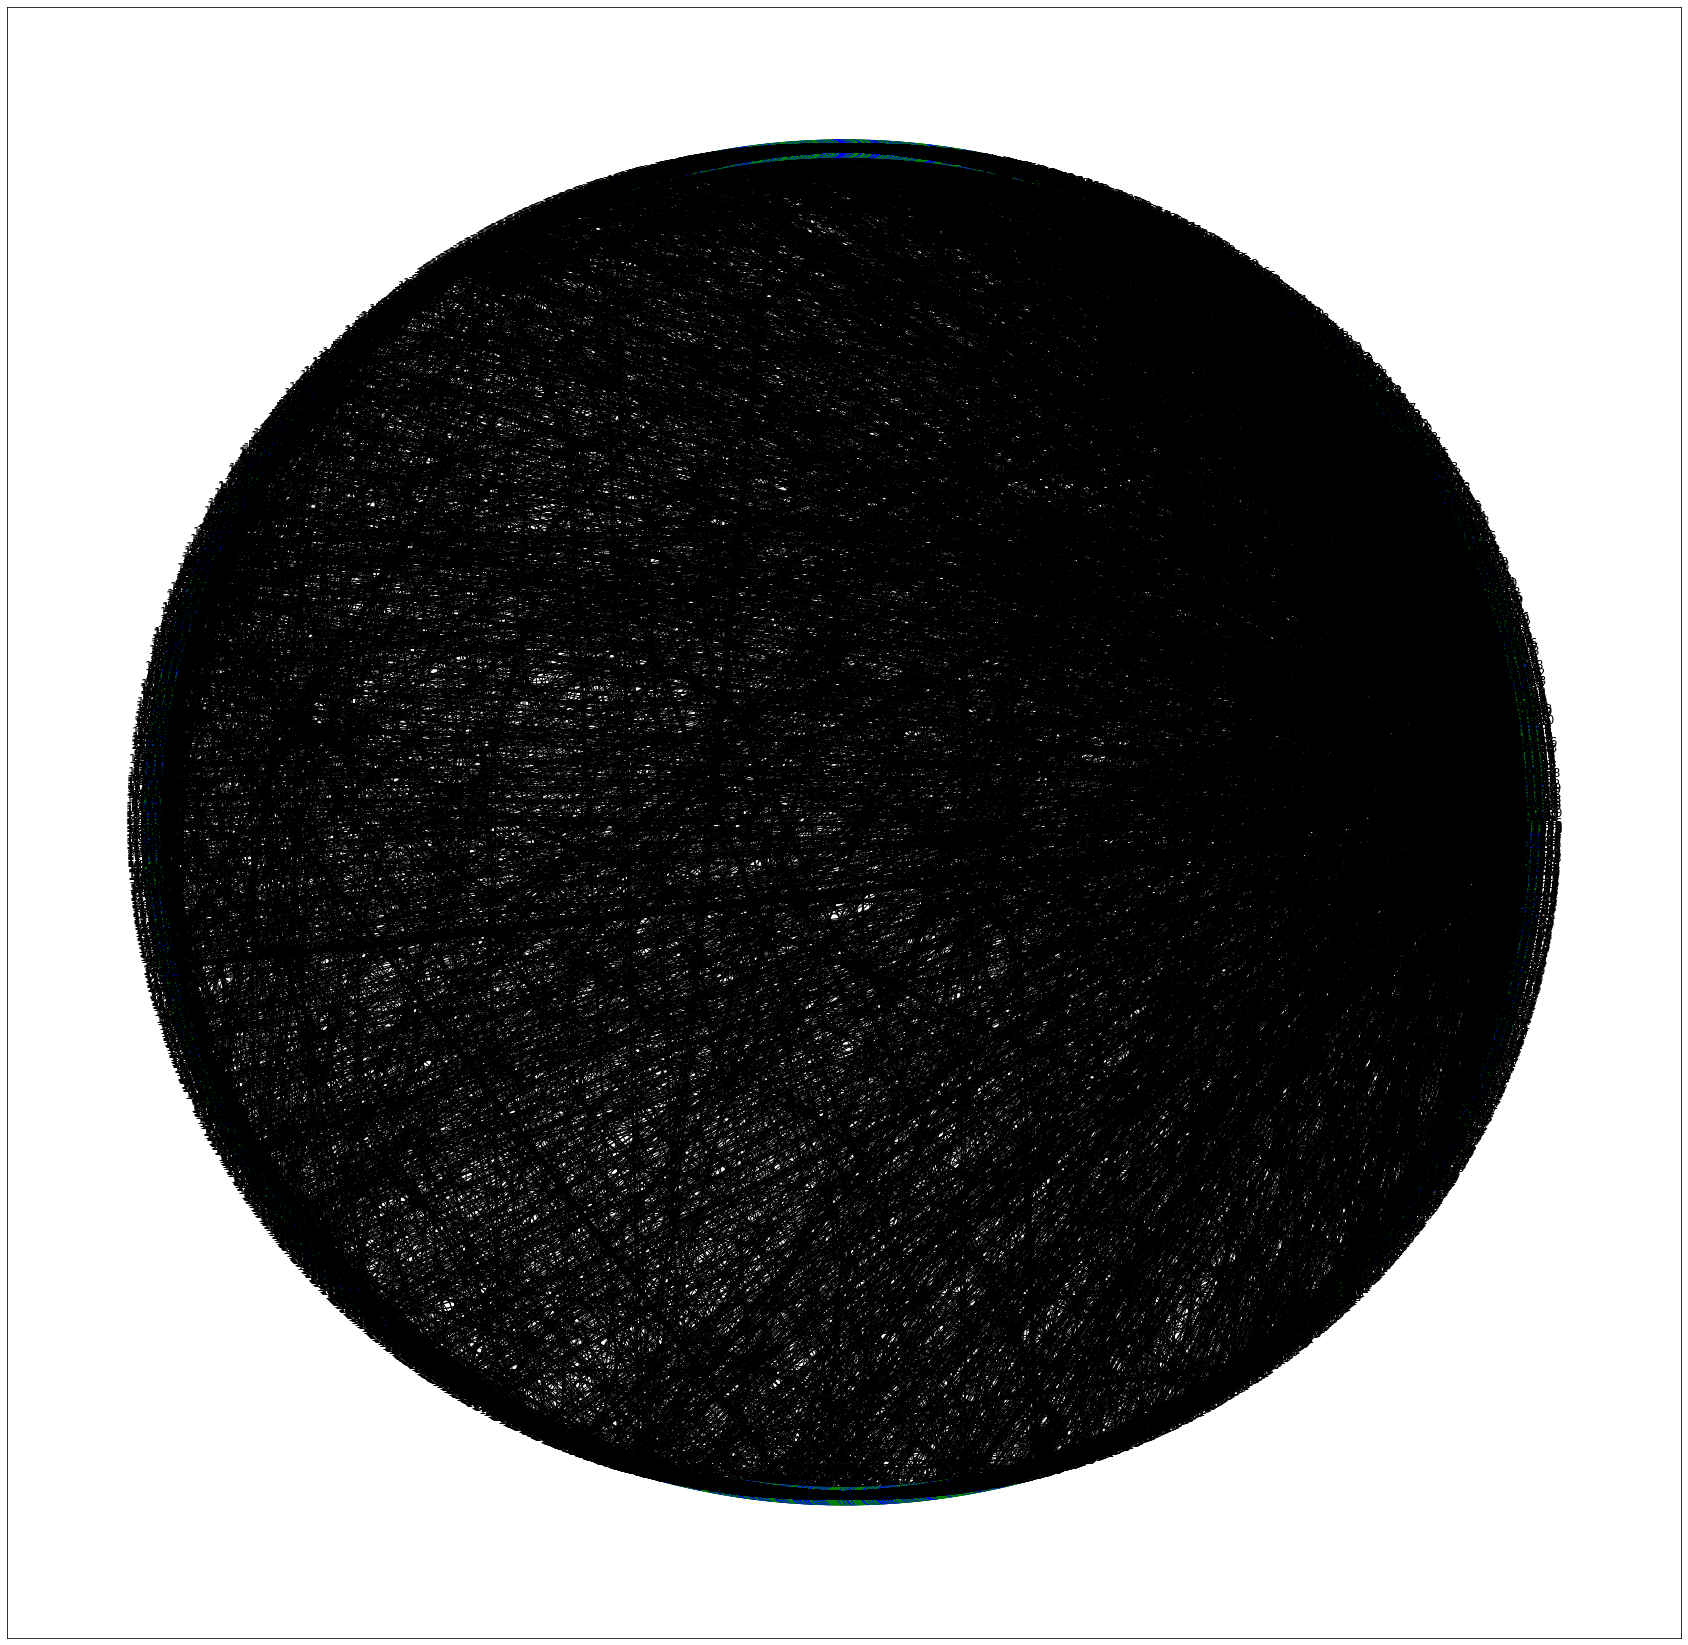

In [354]:
plt.rcParams['figure.figsize'] = [30, 30]

edge_pairs = []

for k in graph_edges:
    for i in graph_edges[k]:
        edge_pairs.append((k, i))

G = nx.DiGraph(directed=True)
G.add_edges_from(edge_pairs)
color_map = []
for node in G:
    if node in type0_nodes:
        color_map.append('blue')
    else: 
        color_map.append('green')      

nx.draw_networkx(G, node_color=color_map, pos=nx.circular_layout(G), arrows=True)
plt.savefig('plot_graph.png', dpi=300, bbox_inches='tight')
plt.show()

In [340]:
pwd

'/home/singh_shruti/workspace/axcell_ws/axcell/notebooks'

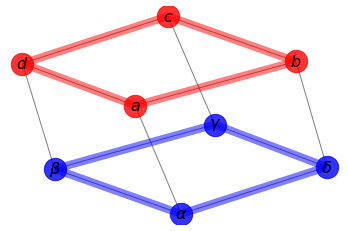

In [330]:
G = nx.cubical_graph()
pos = nx.spring_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos,
                       nodelist=[0, 1, 2, 3],
                       node_color='r',
                       node_size=500,
                       alpha=0.8)
nx.draw_networkx_nodes(G, pos,
                       nodelist=[4, 5, 6, 7],
                       node_color='b',
                       node_size=500,
                       alpha=0.8)

# edges
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_edges(G, pos,
                       edgelist=[(0, 1), (1, 2), (2, 3), (3, 0)],
                       width=8, alpha=0.5, edge_color='r')
nx.draw_networkx_edges(G, pos,
                       edgelist=[(4, 5), (5, 6), (6, 7), (7, 4)],
                       width=8, alpha=0.5, edge_color='b')


# some math labels
labels = {}
labels[0] = r'$a$'
labels[1] = r'$b$'
labels[2] = r'$c$'
labels[3] = r'$d$'
labels[4] = r'$\alpha$'
labels[5] = r'$\beta$'
labels[6] = r'$\gamma$'
labels[7] = r'$\delta$'
nx.draw_networkx_labels(G, pos, labels, font_size=16)

plt.axis('off')
plt.show()

# Finding ICLR type 1 nodes

In [356]:
type1 = []

for k in graph_edges_init:
    for n in graph_edges_init[k]:
        if not n in graph_edges_init:
            type1.append(n)

In [359]:
len(set(type1))

2328

1313

# STRICT

# Part1 - Extraction of new edges using ldb/abl table cell references

In [487]:
all_nodes_init = set()

for n in strict_graph_edges_init:
    all_nodes_init.add(n)
    for neighs in strict_graph_edges_init[n]:
        all_nodes_init.add(neighs)
print(len(all_nodes_init))

3408


In [488]:
graph_edges = strict_graph_edges_init.copy()

In [489]:
type2_nodes = []
completely_p3_new_nodes = []

In [499]:
iclr_global_id_map_for_t0_nodes = {}

In [500]:
# DONE = False
found_in_paper_not_arxiv = 0
fipna_pid = []
bib_seq_not_found = []

# This is edge augmentation so dicts below will also be augmented.
#iclr_yearwise_graph_info = {}
#reverse_iclr_yearwise_graph_info = {}

for k in REF_leaderboard_refs:
    
    
#     title = iclr_arxiv_map[k]["title"].lower()
#     unaccented_title = unidecode.unidecode(title)
#     clean_title = re.sub('[\W_]', '', unaccented_title)
    
#     if clean_title in paper_global_id_dict:
#         self_global_id = paper_global_id_dict[clean_title]
#     else:
#         paper_global_id_dict[clean_title] = len(paper_global_id_dict)
#         self_global_id = paper_global_id_dict[clean_title]
    if not k in all_nodes_init:
        continue
    
    self_global_id = k
    arxiv_id = iclr_ref_arxiv_map[k]
    
    strict_iclr_yearwise_graph_info[arxiv_id] = self_global_id
    strict_reverse_iclr_yearwise_graph_info[self_global_id] = arxiv_id
    
    iclr_global_id_map_for_t0_nodes[k] = self_global_id
    
    try:
        if 'count' in REF_leaderboard_refs[k] and REF_leaderboard_refs[k]["count"] > 0 and k in paper_bbl_dict: #k.startswith("2017"):# or k.startswith("2018"):
            
            ldb_abl_keys = []
            if "ldb" in REF_leaderboard_refs[k]['refs'] and REF_leaderboard_refs[k]['refs']["ldb"]:
                ldb_abl_keys.append("ldb")
            if "abl" in REF_leaderboard_refs[k]['refs'] and REF_leaderboard_refs[k]['refs']["abl"]:
                ldb_abl_keys.append("abl")
            
            for ldbabl_ref_key in ldb_abl_keys:
                for ldb_ref in REF_leaderboard_refs[k]['refs'][ldbabl_ref_key]:
                    m = re.search("bib[a]?-bib([0-9][0-9]?)", ldb_ref)
                    if m:
                        seq_key = int(m.group(1))
                        
                        if k in [1196205, 1180756, 1177132, 1163147, 1195875]:
                            m_dash = re.search("bib[a]?-bib[0-9][0-9]?\'>([0-9][0-9]?)\</ref", ldb_ref)
                            if m_dash:
                                seq_key = int(m_dash.group(1))
                        
                        found = False
                        partially_found = False
                        for paper_bib_entry in paper_bbl_dict[k].values():
                            if "bib-seq" in paper_bib_entry and paper_bib_entry["bib-seq"] == seq_key:
                                if "strict_seq_id" in paper_bib_entry:
                                    found = True
                                    if paper_bib_entry["strict_seq_id"] in all_nodes_init:
                                        graph_edges[self_global_id].add(paper_bib_entry["strict_seq_id"])
                                        type2_nodes.append(self_global_id)
                                    else:
                                        completely_p3_new_nodes.append(paper_bib_entry["strict_seq_id"])
                                else:
                                    partially_found = True
                                    found_in_paper_not_arxiv += 1
                        if not found and not partially_found:
                            bib_seq_not_found.append((k, ldb_ref))
                    else:
                        m = re.search("bib[a]?-bibx([0-9][0-9]?)\'>", ldb_ref)
                        if m:
                            seq_key = int(m.group(1))
                            found = False
                            partially_found = False
                            for paper_bib_entry in paper_bbl_dict[k].values():
                                if "bib-seq" in paper_bib_entry and paper_bib_entry["bib-seq"] == seq_key:
                                    if "strict_seq_id" in paper_bib_entry:
                                        found = True
                                        if paper_bib_entry["seq_id"] in all_nodes_init:
                                            graph_edges[self_global_id].add(paper_bib_entry["strict_seq_id"])
                                            type2_nodes.append(self_global_id)
                                        else:
                                            completely_p3_new_nodes.append(paper_bib_entry["strict_seq_id"])
                                    else:
                                        partially_found = True
                                        found_in_paper_not_arxiv += 1
                            if not found and not partially_found:
                                bib_seq_not_found.append((k, ldb_ref))
                        else:
                            print("insucc bib re match: ", k, ldb_ref)
            if not self_global_id in graph_edges:
                fipna_pid.append(k)
    except Exception as ex:
        print("Error: ", k, ex)

insucc bib re match:  180383 <ref id='S4-F3'>3</ref>
insucc bib re match:  180383 <ref id='S4-F3'>3</ref>
insucc bib re match:  181005 <ref id='S4-E17'>17</ref>
insucc bib re match:  1180880 <ref id='S3-E11'>11</ref>
insucc bib re match:  1180880 <ref id='S2-E1'>1</ref>
insucc bib re match:  1180880 <ref id='S3-E9'>9</ref>
insucc bib re match:  1180880 <ref id='S3-E10'>10</ref>
insucc bib re match:  1090796 <ref id='S2-T1'>1</ref>
insucc bib re match:  960425 <ref id='S3-E6'>6</ref>
insucc bib re match:  1133440 <ref id='S3-F2'>2</ref>
insucc bib re match:  1133440 <ref id='S4-F4'>4</ref>
insucc bib re match:  1158301 <ref id='S2-E3'>3</ref>
insucc bib re match:  330961 <ref id='S3-F2'>2</ref>
insucc bib re match:  683338 <ref id='footnote3'>3</ref>
insucc bib re match:  683338 <ref id='footnote2'>2</ref>
insucc bib re match:  19856 <ref id='S4-F3'>3</ref>
insucc bib re match:  429843 <ref id='S4-SS1'>4.1</ref>
insucc bib re match:  429843 <ref id='S4-SS2'>4.2</ref>
insucc bib re match

# Part 2

In [501]:
found_in_paper_not_arxiv_p2 = []

for k,v in REF_full_text_refs_dict.items():
    
    if not k in all_nodes_init:
        continue
    
    self_global_id = k
    arxiv_id = iclr_ref_arxiv_map[k]
    
    strict_iclr_yearwise_graph_info[arxiv_id] = self_global_id
    strict_reverse_iclr_yearwise_graph_info[self_global_id] = arxiv_id
    
    iclr_global_id_map_for_t0_nodes[k] = self_global_id
    
    for i in v:
        m = re.search("\\\cite[ptyear\[\]\*]*?\{([^\{]*)\}", i)
        cits = []
        if m:
            p = m.group(1)
            cits = p.split(",")
        if k in paper_bbl_dict:
            for cit_key in cits:
                if cit_key in REF_paper_bbl_dict[k]:
                    if "strict_seq_id" in REF_paper_bbl_dict[k][cit_key]:
                        if REF_paper_bbl_dict[k][cit_key]["strict_seq_id"] in all_nodes_init:
                            graph_edges[self_global_id].add(REF_paper_bbl_dict[k][cit_key]["strict_seq_id"])
                            type2_nodes.append(self_global_id)
                        else:
                            completely_p3_new_nodes.append(REF_paper_bbl_dict[k][cit_key]["strict_seq_id"])
                    else:
                        found_in_paper_not_arxiv_p2.append(REF_paper_bbl_dict[k][cit_key]["text"])
#     if not self_global_id in graph_edges:
#         print(k)

In [503]:
with open("graph1/iclr_global_id_map_for_t0_nodes.pkl", "wb") as f:
    pickle.dump(iclr_global_id_map_for_t0_nodes, f)

In [492]:
len(completely_p3_new_nodes)

1859

In [493]:
new_edge_count = 0
for n in graph_edges:
    new_edge_count += len(graph_edges[n])
print(new_edge_count)

8797


In [494]:
8797 - 5370

3427

In [495]:
st_uniq_nodes = set()
for k, v in graph_edges.items():
    st_uniq_nodes.add(k)
    for i in v:
        st_uniq_nodes.add(i)
print(len(st_uniq_nodes))

3408


In [496]:
len(strict_graph_edges_init), len(graph_edges)

(1193, 2102)

In [497]:
strict_type0_nodes = list(strict_graph_edges_init.keys())

In [498]:
with open("graph1/STRICT_graph_edges_dict.pkl", "wb") as f:
    pickle.dump(graph_edges, f)

with open("graph1/STRICT_stage0_graph_edges_dict.pkl", "wb") as f:
    pickle.dump(strict_graph_edges_init, f)

with open("graph1/STRICT_type0_nodes_list.pkl", "wb") as f:
    pickle.dump(strict_type0_nodes, f)

# # Actually saving this is not entirely correct because this contains a subset of type1 nodes (the set of type1_nodes which also adds new edges in the existing graph)
# with open("graph1/type1_nodes.pkl", "wb") as f:
#     pickle.dump(type2_nodes, f)

# with open("graph1/level2_nodes_invisible.pkl", "wb") as f:
#     pickle.dump(completely_p3_new_nodes, f)

# Graph Statistics

In [434]:
def DFSUtil(temp, v, nodes):
    # Mark the current vertex as visited 
    visited[v] = True

    # Store the vertex to list 
    temp.append(v)

    # Repeat for all vertices adjacent 
    # to this vertex v 
    for i in nodes[v]: 
        if visited[i] == False: 
            temp = DFSUtil(temp, i, nodes) 
    return temp 

In [435]:
def connectedComponents(nodes): 
    cc = [] 
    for i in nodes: 
        visited[i] = False
        for j in nodes[i]:
            visited[j] = False
    
    for v in nodes:
        if visited[v] == False: 
            cc.append(DFSUtil([], v, nodes)) 
    return cc

In [436]:
visited = {}
graph_edges_for_comp = defaultdict(set)
# graph_edges_for_comp = graph_edges.copy()

for i in graph_edges:
    graph_edges_for_comp[i] = set()
    for n in graph_edges[i]:
        graph_edges_for_comp[n] = set()

for i in graph_edges:
    graph_edges_for_comp[i] = graph_edges[i]

cc = connectedComponents(graph_edges_for_comp)

In [437]:
sorted_clusters = sorted(cc, key=lambda x:len(x), reverse=True)

In [438]:
len(sorted_clusters[0])

87

In [439]:
len(cc)

1115

In [440]:
cl_lens = []

for cluster in cc:
    cl_lens.append(len(cluster))

In [441]:
max(cl_lens), min(cl_lens), sum(cl_lens)

(87, 1, 3408)

In [442]:
sorted(cl_lens, reverse=True)

[87,
 51,
 27,
 26,
 20,
 19,
 18,
 17,
 16,
 15,
 14,
 14,
 14,
 13,
 13,
 13,
 13,
 12,
 12,
 12,
 12,
 12,
 12,
 11,
 11,
 11,
 11,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4

In [443]:
c = 0
for i in cl_lens:
    if i > 1:
        c+=1
c

761

In [444]:
len(cl_lens)

1115

In [445]:
ec = 0

for i in sorted_clusters[0]:
    ec += len(graph_edges[i])
print(ec)

ec = 0

for i in sorted_clusters[1]:
    ec += len(graph_edges[i])
print(ec)

ec = 0

for i in sorted_clusters[2]:
    ec += len(graph_edges[i])
print(ec)

277
137
104


In [449]:
# Highest in-degree
hindeg = defaultdict(int)

for k in graph_edges_for_comp:
    for i in graph_edges_for_comp[k]:
        hindeg[i] += 1

In [453]:
sorted_hin_degree = sorted(hindeg.items(), key=lambda x:x[1], reverse=True)
sorted_hin_degree

[(527483, 191),
 (1090796, 75),
 (224770, 65),
 (36246, 52),
 (80174, 51),
 (575568, 48),
 (108849, 46),
 (1133440, 45),
 (575986, 45),
 (596867, 44),
 (551035, 43),
 (599515, 42),
 (739903, 41),
 (832594, 41),
 (890616, 40),
 (987677, 39),
 (210556, 38),
 (667446, 38),
 (465168, 35),
 (1105195, 35),
 (1163015, 35),
 (577783, 33),
 (446477, 30),
 (779070, 29),
 (718033, 29),
 (1039956, 29),
 (111966, 28),
 (962076, 28),
 (157588, 28),
 (542395, 28),
 (107989, 28),
 (1155834, 27),
 (396737, 26),
 (1050603, 26),
 (174321, 26),
 (1098664, 26),
 (699695, 25),
 (340912, 25),
 (888571, 24),
 (75420, 24),
 (111996, 24),
 (1131319, 24),
 (585148, 23),
 (1147022, 23),
 (172080, 23),
 (1044012, 22),
 (40517, 22),
 (523029, 22),
 (549955, 21),
 (1137843, 21),
 (776475, 21),
 (1034028, 20),
 (611241, 20),
 (590287, 20),
 (993944, 20),
 (419660, 20),
 (768813, 20),
 (456347, 19),
 (838523, 19),
 (903195, 19),
 (897931, 19),
 (502887, 18),
 (1053206, 18),
 (201733, 18),
 (958605, 18),
 (102007, 18),

In [463]:
first_7 = 0
for it in sorted_hin_degree:
    first_7 += 1
    print(it[1], iclr_ref_arxiv_map[it[0]])
    if first_7 > 7:
        break

191 1512.03385
75 1409.1556
65 1605.07146
52 1608.06993
51 1412.6980
48 1706.06083
46 1706.03762
45 1603.05027


In [469]:
# Highest out-degree
num_neighs = defaultdict(int)
for k in graph_edges_for_comp:
    num_neighs[k] = len(graph_edges_for_comp[k])

In [470]:
sorted_hout_degree = sorted(num_neighs.items(), key=lambda x:x[1], reverse=True)
sorted_hout_degree[0:7]

[(1170004, 25),
 (1199331, 25),
 (890415, 22),
 (1162305, 21),
 (1181806, 21),
 (1161105, 21),
 (465168, 20)]

In [482]:
p = sorted_hout_degree[0:10]
for i in p:
    print(i[1], reverse_iclr_yearwise_graph_info[i[0]], end="\t")
    try:
        print(ORG_iclr_arxiv_map[reverse_iclr_yearwise_graph_info[i[0]]]["label"], ORG_iclr_arxiv_map[reverse_iclr_yearwise_graph_info[i[0]]]["title"], end="\n\n")
    except Exception:
        print("\n")
        continue

25 1901.02860	

25 2020_SkgS2lBFPS	Reject A Bilingual Generative Transformer for Semantic Sentence Embedding

22 2018_r1kjEuHpZ	Reject Learning Less-Overlapping Representations

21 2019_HyxPx3R9tm	Accept Variational Discriminator Bottleneck: Improving Imitation Learning, Inverse RL, and GANs by Constraining Information Flow

21 2020_BJgAf6Etwr	Reject XLDA: Cross-Lingual Data Augmentation for Natural Language Inference and Question Answering

21 1809.05053	

20 2017_r1Ue8Hcxg	Accept Neural Architecture Search with Reinforcement Learning

20 2019_SJzuHiA9tQ	Reject Generative Adversarial Network Training is a Continual Learning Problem

19 2018_H1cWzoxA-	Accept Bi-Directional Block Self-Attention for Fast and Memory-Efficient Sequence Modeling

19 2018_rkdU7tCaZ	Reject Dynamic Evaluation of Neural Sequence Models

